In [22]:
import requests, zipfile, io, os

import pandas as pd
import numpy as np

import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import contextily as ctx

import folium
import branca

In [23]:
#min number of visits present for an entry to be taken into account
MIN_VISITS = 150

#use the data from the following year (2018, 2019 or 2020)
DataYear = '2020'

#municipality to be processed
municipality = 'Dresden'

#Should we reload original csv file? If false, prepared files from cache will be used if available.
Load_Original_Data = False

IsDebug = True

#coordinate systems
source_crs='EPSG:4326'
target_crs='EPSG:3857'

#  read original data and do some preprocessing

In [24]:
#construct filename for datafile based on desired parameters
data_folder = "data\\movebis\\"
data_filename = "geschwindigkeiten_%s" % DataYear
data_fileext = ".csv.tar.gz"
cache_folder = "cache\\"
cache_filename = cache_folder + data_filename + "_%d.csv" % MIN_VISITS

In [25]:
#if cache file does not exist, we have to load original data
if not os.path.isfile(cache_filename):
    Load_Original_Data = True

In [26]:
#for debugging: read the first 10 lines from the file
#data_speed_test = pd.read_csv(data_folder + data_filename + data_fileext, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False, nrows=10)
#data_speed_test

In [27]:
#read CSV-Datei file (caution: it takes quite a while :-))
if (Load_Original_Data):
    data_speed_orig = pd.read_csv(data_folder + data_filename + data_fileext, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
    data_speed_orig

In [28]:
#rename first column to 'geometry' (per default it has the name of the csv file)
if (Load_Original_Data):
    data_speed_orig = data_speed_orig.rename(columns={data_speed_orig.columns[0]: "geometry"}) 
    #data_speed_orig

In [29]:
#keep only links with more than MIN_VISITS visits, so avg. speed might be reliable
if (Load_Original_Data):
    data_speed = data_speed_orig[data_speed_orig.visits > MIN_VISITS].copy()
    len(data_speed)

In [30]:
#save this state of the data into a file
if (Load_Original_Data):
    gdf_speed.to_csv(cache_folder + data_filename + "_%d.csv" % MIN_VISITS, index=False)

In [31]:
#if we don't want to reread the original data, use the cached file
if not Load_Original_Data:
    data_speed = pd.read_csv(cache_folder + data_filename + "_%d.csv" % MIN_VISITS)
    #data_speed['geometry'] = data_speed['geometry'].apply(wkt.loads)

#if IsDebug:
#    print(data_speed)

In [32]:
#convert column with the coordinates into the right data type
data_speed['geometry'] = data_speed['geometry'].apply(wkt.loads)

In [33]:
#transfer to GeoDataFrame and adjust coordinate system 
gdf_speed = gpd.GeoDataFrame(data_speed, geometry='geometry', crs=source_crs)
gdf_speed = gdf_speed.to_crs(target_crs)

# Load desired shape file

In [34]:
#construct filename for datafile based on desired parameters
shapefile_folder = "data\\shapefiles\\"
shapefile_filename = "gem" #Municipalities(='gem') or Counties(='kreis')
shapefile_fileext = ".shp"
cache_filename = cache_folder + data_filename + "_%d_%s.csv" % (MIN_VISITS, municipality)
#cache_filename

In [35]:
#if cache file does not exist, we have to load original data
if not os.path.isfile(cache_filename):
    Load_Original_Data = True

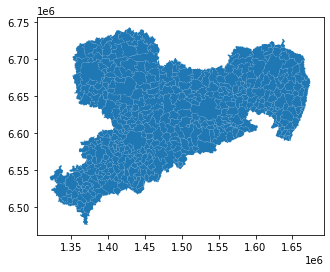

In [36]:
#load all shapes
gem_sn = gpd.read_file(shapefile_folder + shapefile_filename + shapefile_fileext)
gem_sn = gem_sn.to_crs(target_crs)
if IsDebug:
    gem_sn.plot()
    gem_sn

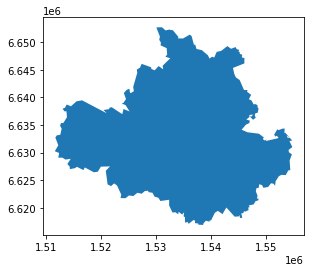

In [37]:
#only use boarders of our municipality
poly_municipality = gem_sn[gem_sn.ORTSNAME == municipality]
if IsDebug:
    poly_municipality.plot()

In [38]:
#Filter data to our municipality (this will take a while :-)) and save to cache file
if (Load_Original_Data):
    gdf_speed_municipality = gpd.clip(gdf_speed, poly_municipality)
    gdf_speed_municipality.to_csv(cache_filename, index=False)

In [39]:
if not Load_Original_Data: 
    gdf_speed_municipality = pd.read_csv(cache_filename) 
    gdf_speed_municipality['geometry'] = gdf_speed_municipality['geometry'].apply(wkt.loads)
    gdf_speed_municipality = gpd.GeoDataFrame(gdf_speed_municipality, geometry=gdf_speed_municipality['geometry'])
    gdf_speed_municipality.crs = target_crs
    #print(gdf_speed_municipality)

# Results

In [40]:
#construct filename for datafile based on desired parameters
results_folder = "results\\"
results_filename = results_folder + data_filename + "_%d_%s" % (MIN_VISITS, municipality)

data_field = 'avg_speed_kmh'

carto_attribution='\u0026copy; \u003ca href=\"http://www.openstreetmap.org/copyright\"\u003eOpenStreetMap\u003c/a\u003e contributors \u0026copy; \u003ca href=\"http://cartodb.com/attributions\"\u003eCartoDB\u003c/a\u003e, CartoDB \u003ca href =\"http://cartodb.com/attributions\"\u003eattributions\u003c/a\u003e' # <-- note this
custom_attribution=carto_attribution + ' | \u0026copy; \u003ca href=\"https://www.mcloud.de/web/guest/suche/-/results/suche/relevance/movebis/0/detail/33427A5A-0ADB-40B1-8A1A-390B67B0380B"\u003eMovebis\u003c/a\u003e'


## Display the data on a map

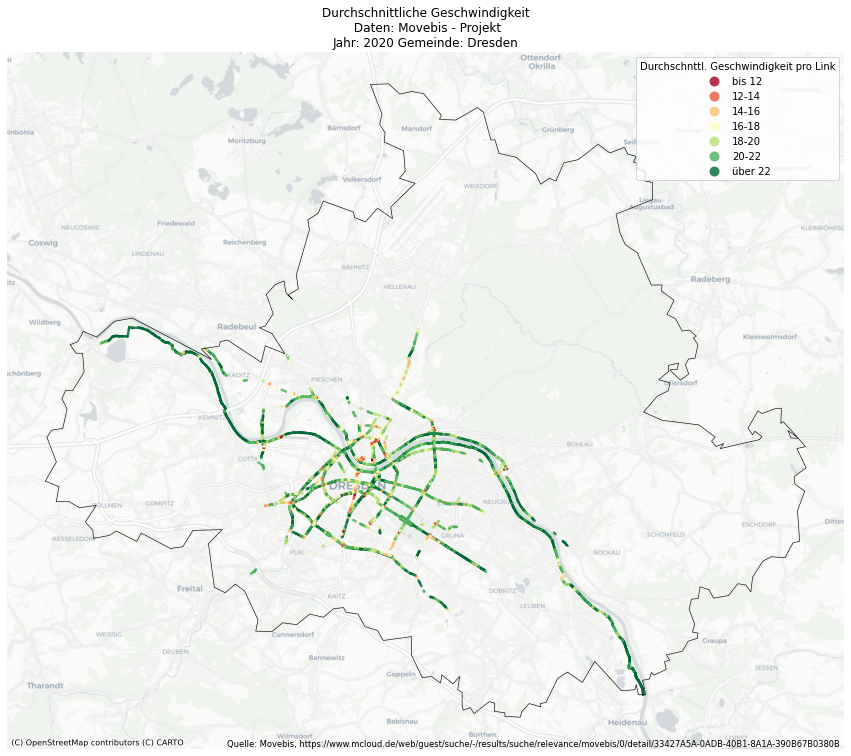

In [41]:
df_plot = gdf_speed_municipality.copy()
df_plot.geometry=df_plot.buffer(70)

label_list=[
    'bis 12',
    '12-14',
    '14-16',
    '16-18',
    '18-20',
    '20-22',
    'über 22']

ax=df_plot.plot(column=data_field, scheme='UserDefined', figsize=(15,15), legend=True, alpha=0.8, cmap='RdYlGn',# linewidths=1,
            classification_kwds={
             'bins':[12,14,16,18,20,22]
         },
            legend_kwds = { 
                #'numpoints':1,
                'bbox_to_anchor':(1.0, 1.0),
                'title': "Durchschnttl. Geschwindigkeit pro Link",
                'labels':label_list }
            )

#adding municipality border layer
fin_plot=poly_municipality.plot(facecolor="none", edgecolor='black', linewidths=0.6, figsize=(15,15), ax=ax)#, weight=1)

#adding basemap
ctx.add_basemap(fin_plot, source=ctx.providers.CartoDB.Positron)

fig = ax.get_figure()

#remove axis
ax.set_axis_off()
fin_plot.set_axis_off()

#add title
ax.set_title('Durchschnittliche Geschwindigkeit\n Daten: Movebis - Projekt\nJahr: %s Gemeinde: %s' % (DataYear, municipality))

#Quelle
ax.text(0.995, 0.004, transform=ax.transAxes, horizontalalignment='right', size='small',\
        s="Quelle: Movebis, https://www.mcloud.de/web/guest/suche/-/results/suche/relevance/movebis/0/detail/33427A5A-0ADB-40B1-8A1A-390B67B0380B")

fig.savefig(results_filename + '.png', bbox_inches='tight', pad_inches = 0)

## HTML with zoomable map

In [42]:
df = gdf_speed_municipality.copy()
df[data_field]=df[data_field].round(0)

#TODO: calculate center of map from poly_municipality
location_lat = 51.05
location_lon = 13.75

#create map with tile source
m = folium.Map(location=[location_lat, location_lon], 
               zoom_start=12, 
                tiles='https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png', 
                attr=custom_attribution)

colorscale = branca.colormap.LinearColormap(['red','orange','yellow','green','green'], index=None, vmin=12, vmax=25, caption=data_field)

def style_function(feature):
    col=feature['properties'][data_field]
    return {
        'opacity': 0.8,
        'weight': 3,
        'color': 'grey' if col is None else colorscale(col)
    }

def highlight_function(feature):
    return {
         'weight': 8,
        'color': 'grey'
    }

dummy=folium.GeoJson(
    df,
    tooltip=folium.GeoJsonTooltip(fields=[data_field, 'visits']),
    style_function=style_function,
    highlight_function=highlight_function
).add_to(m)

#colorscale.caption = field
m.add_child(colorscale)

m.save(results_filename + '.html')